In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import pandas as pd
class AsianOptionPricer:
    """
    A class for pricing Asian options using Monte Carlo simulation, with an
    option to use the control variate technique based on the geometric Asian option.
    """
    def __init__(self, S0, sigma, r, T, K, n, option_type):
        """
        Initializes the pricer with given parameters.
        """
        self.S0 = S0  # Initial stock price
        self.sigma = sigma  # Volatility of the stock
        self.r = r  # Risk-free interest rate
        self.T = T  # Time to maturity of the option
        self.K = K  # Strike price of the option
        self.n = n  # Number of observation times
        self.option_type = option_type  # 'call' or 'put'

    def generate_price_paths(self, M, dt):
        """
        Generates simulated price paths for the underlying asset using Geometric Brownian Motion.
        """
        np.random.seed(100)  # Fixing the seed for reproducibility
        drift = np.exp((self.r - 0.5 * self.sigma**2) * dt)
        Z = np.random.randn(M, self.n)
        growth_factors = drift * np.exp(self.sigma * np.sqrt(dt) * Z)
        S_paths = self.S0 * np.cumprod(growth_factors, axis=1)
        return S_paths






    def price_geometric_option(self):
        """
        Prices a geometric Asian option using the closed-form solution.
        """
        dt = self.T / self.n
        sigsqT = self.sigma**2 * self.T * (self.n + 1) * (2 * self.n + 1) / (6 * self.n* self.n)
        muT = (self.r - 0.5 * self.sigma**2) * self.T * (self.n + 1) / (2*self.n)+0.5*sigsqT
        d1 = (np.log(self.S0 / self.K) + (muT + 0.5 * sigsqT)) / np.sqrt(sigsqT)
        d2 = d1 - np.sqrt(sigsqT)
        if self.option_type == 'call':
            N1 = norm.cdf(d1)
            N2 = norm.cdf(d2)
            price = np.exp(-self.r * self.T) * (self.S0 * np.exp(muT) * N1 - self.K * N2)
        else:
            N1 = norm.cdf(-d1)
            N2 = norm.cdf(-d2)
            price = np.exp(-self.r * self.T) * (self.K * N2 - self.S0 * np.exp(muT) * N1)
        return {'geometric_price': price}





    def price_arithmetic_option(self, M, use_control_variate=True):
        """
        Prices an arithmetic Asian option using Monte Carlo simulation.
        """
        dt = self.T / self.n
        paths = self.generate_price_paths(M, dt)
        arithmetic_means = np.mean(paths, axis=1)
        geometric_means = np.exp(np.sum(np.log(paths), axis=1) / self.n)

        if self.option_type == 'call':
            arithPayoff = np.exp(-self.r * self.T) * np.maximum(arithmetic_means - self.K, 0)
            geometric_payoffs=np.exp(-self.r * self.T) * np.maximum(geometric_means - self.K, 0)
        else:
            arithPayoff = np.exp(-self.r * self.T) * np.maximum(self.K - arithmetic_means, 0)
            geometric_payoffs = np.exp(-self.r * self.T) * np.maximum(self.K - geometric_means, 0)
        

        if not use_control_variate:
            Pmean = np.mean(arithPayoff)
            Pstd = np.std(arithPayoff)
            confmc = [Pmean - 1.96 * Pstd / np.sqrt(M), Pmean + 1.96 * Pstd / np.sqrt(M)]
            return {'arithmetic_price': Pmean, 'confidence_interval': confmc}





        else :
            geometric_price = self.price_geometric_option()['geometric_price']
            cov_xy =  np.mean(np.multiply(arithPayoff,geometric_payoffs))- np.mean(arithPayoff)*np.mean(geometric_payoffs) 
            theta = cov_xy / np.var(geometric_payoffs)
            Z=arithPayoff + theta * (geometric_price - geometric_payoffs)

            Zmean = np.mean(Z)
            Zstd = np.std(Z)
            confcv = [Zmean - 1.96 * Zstd / np.sqrt(M), Zmean + 1.96 * Zstd / np.sqrt(M)]
            return {'arithmetic_price': Zmean, 'confidence_interval': confcv}
      


C:\Users\27421\AppData\Local\Temp\ipykernel_18544\2216028151.py:91: RuntimeWarning: invalid value encountered in scalar divide
  theta = cov_xy / np.var(geometric_payoffs)


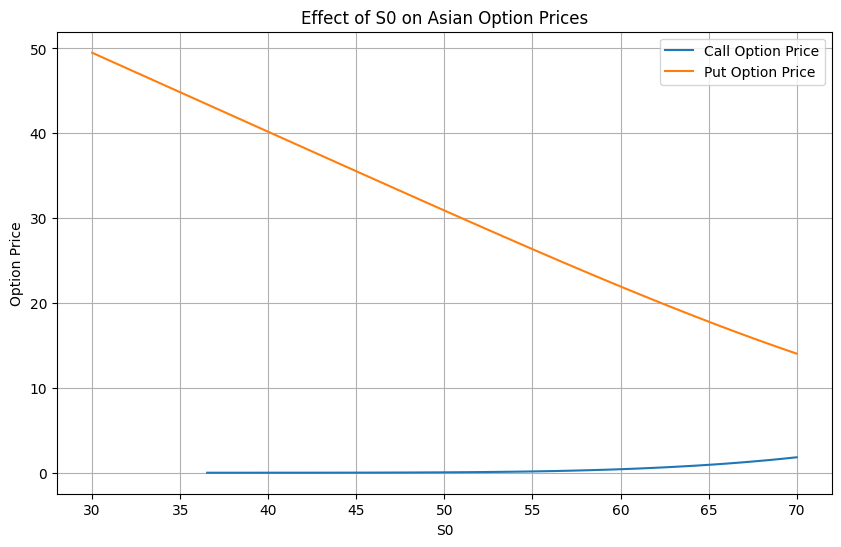

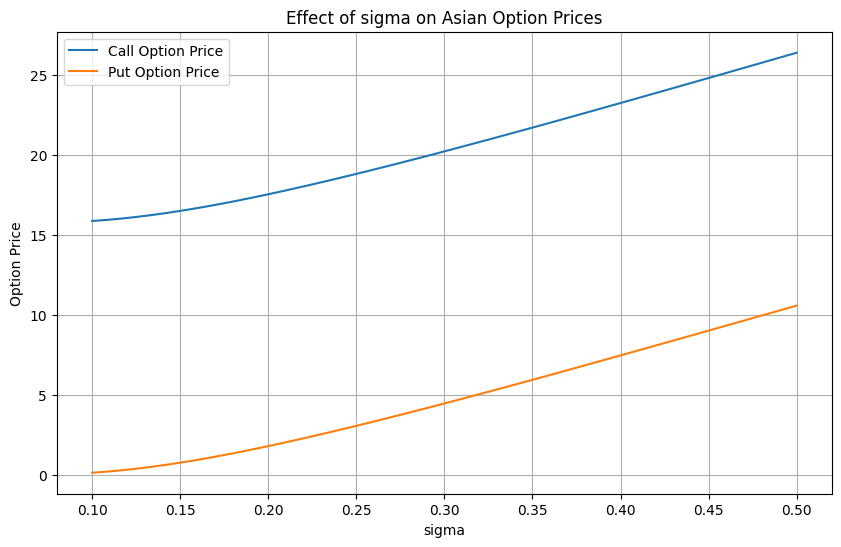

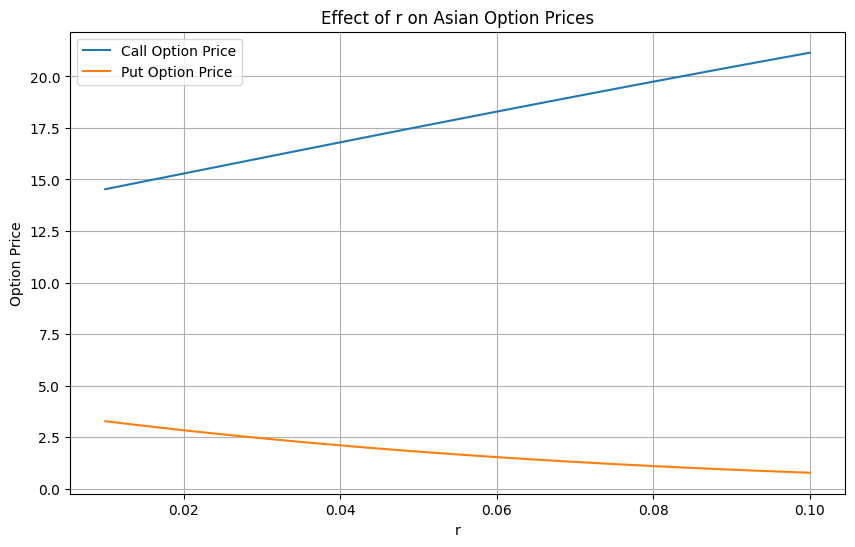

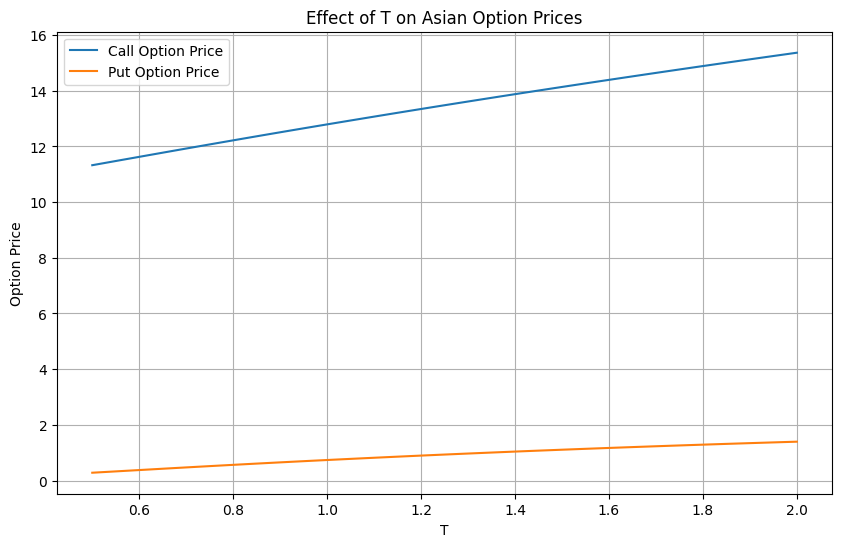

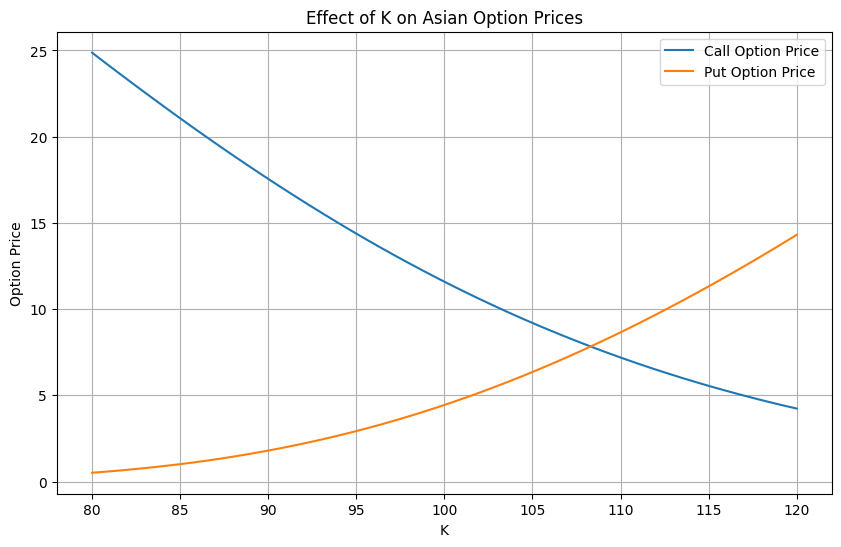

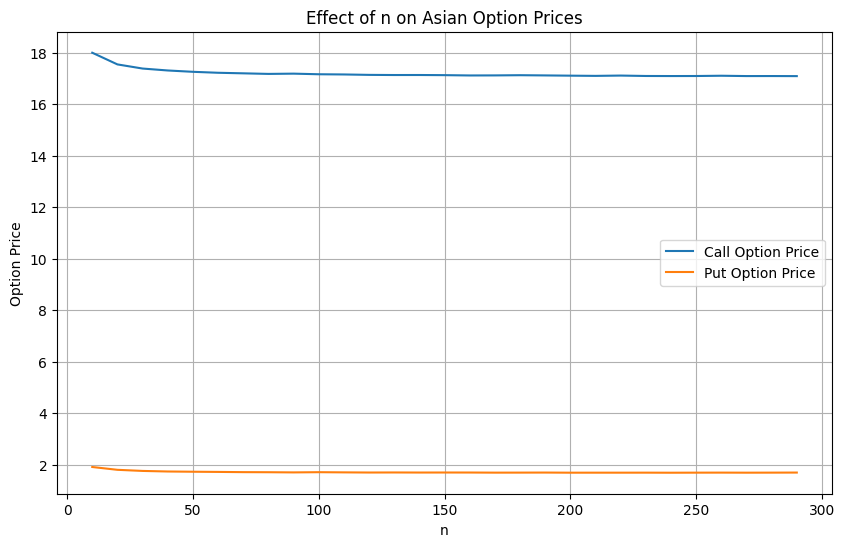

In [4]:

class OptionAnalysis(AsianOptionPricer):
    def analyze_effect(self, M, factor_name, factor_range):
        call_prices = []
        put_prices = []
        original_value = getattr(self, factor_name)

        for factor_value in factor_range:
            setattr(self, factor_name, factor_value)
            self.option_type = 'call'
            call_price = self.price_arithmetic_option(M)['arithmetic_price']
            call_prices.append(call_price)

            self.option_type = 'put'
            put_price = self.price_arithmetic_option(M)['arithmetic_price']
            put_prices.append(put_price)

        setattr(self, factor_name, original_value)

        plt.figure(figsize=(10, 6))
        plt.plot(factor_range, call_prices, label='Call Option Price')
        plt.plot(factor_range, put_prices, label='Put Option Price')
        plt.title(f'Effect of {factor_name} on Asian Option Prices')
        plt.xlabel(factor_name)
        plt.ylabel('Option Price')
        plt.grid(True)
        plt.legend()

        # Save the plot to a file
        plt.savefig(f"{factor_name}_effect_on_Asian_Option_Prices.png")
        plt.show()

# Initialize the option pricer instance
pricer = OptionAnalysis(S0=100, sigma=0.2, r=0.05, T=3, K=90, n=20,option_type='call')

# Analyze the effect of initial stock price (S0) on the option price
pricer.analyze_effect(M=10000, factor_name='S0', factor_range=np.linspace(30, 70, 50))

# Analyze the effect of volatility (sigma) on the option price
pricer.analyze_effect(M=10000, factor_name='sigma', factor_range=np.linspace(0.1, 0.5, 50))

# Analyze the effect of risk-free interest rate (r) on the option price
pricer.analyze_effect(M=10000, factor_name='r', factor_range=np.linspace(0.01, 0.1, 50))

# Analyze the effect of time to maturity (T) on the option price
pricer.analyze_effect(M=10000, factor_name='T', factor_range=np.linspace(0.5, 2, 50))

# Analyze the effect of strike price (K) on the option price
pricer.analyze_effect(M=10000, factor_name='K', factor_range=np.linspace(80, 120, 50))

# Analyze the effect of number of observation points (n) on the option price
pricer.analyze_effect(M=10000, factor_name='n', factor_range=np.arange(10, 300, 10))
